## Joint-domain (hybrid) data fitting and validation

This notebook illustrates the basics of fitting joint-domain ("hybrid") impedance data, which allows us to measure impedance spectra an order of magnitude more quickly than with the conventional frequency-domain technique. 
Hybrid data comprises conventional frequency-domain impedance data covering the high frequency range (typically $\sim 1$ MHz to $\sim 100$ Hz) and time-domain chronoamperometry data covering the low frequency range (typically $\sim 100$ Hz to $\sim 1$ mHz). These two data components are combined in a single step using the DRT transformation.

This notebook illustrates the process with an exemplary experimental dataset, collected from a solid-state battery at rest (open circuit). The cell comprises a composite NCM-LPSCl cathode, an LPSCl separator, and an InLi alloy counter electrode. First, a hybrid measurement was performed, including a time-domain chronopotentiometry step in the range 100 Hz to 10 mHz, followed by a high-frequency EIS measurement in the range 7 MHz to 100 Hz. For comparison, a conventional EIS measurement was performed over the full frequency range from 7 MHz to 10 mHz. We extract the DRT and impedance from the hybrid measurement and validate the result against the conventional measurement.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
# If the notebook magic line below breaks, you can just use "%matplotlib inline" instead
%matplotlib widget
from numpy import ndarray
import pandas as pd
from typing import Optional
from pathlib import Path

from hybdrt.models import DRT
import hybdrt.plotting as hplt
from hybdrt.preprocessing import downsample_data
from hybdrt.utils.eis import complex_from_polar

from hybdrt.dataload.reader import read_chrono, read_eis

# Import from galvani (https://github.com/echemdata/galvani)
from galvani.BioLogic import MPRfile

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions for data processing

Because hybrid measurements often use customized experiment settings, data loading functions may need to be constructed on a case-by-case basis. In this example, the hybrid data and validation EIS measurement are contained in a single EC-Lab mpr file from a Modulo Batt (MB) sequence. The functions below are used to read the file and parse the conventional EIS and hybrid measurement components.

In [13]:
# Functions for extracting/processing chrono and EIS data from Biologic MPR files
def get_tiv(data):
    # Get time, current, voltage from mpr.data
    return data["time/s"], data["I/mA"] * 1e-3, data["Ewe/V"]

def remove_short_samples(
        times: ndarray,
        data: ndarray,
        min_step: Optional[float] = None):
    # Remove time-domain samples with anomalously short time steps
    if len(times) > 1:
        # Get time deltas
        dt = np.insert(np.diff(times), 0, np.inf)

        if min_step is None:
            # Set minimum step time to 90% of median sample period
            min_step = np.median(dt) * 0.9

        # Keep points that exceed the minimum step time
        mask = dt >= min_step

        return data[mask]
    return data

def process_tiv(times, i_signal, v_signal):
    # First remove short samples - these arise due to a Biologic bug
    tiv_array = remove_short_samples(times, np.array([times, i_signal, v_signal]).T)
    
    # Trim erroneous first point - Biologic bug
    tiv_array = tiv_array[1:]
    
    if len(tiv_array) == 0:
        # Empty array
        return 
    else:
        # Then downsample and filter
        # Convert back to tuple
        tiv = tuple([tiv_array[:, i] for i in range(3)])
        
        # Downsample and filter I and V
        # step_index = identify_steps(tiv[1], allow_consecutive=False, rthresh=50)
        sample_times, sample_i, sample_v, sample_index = downsample_data(*tiv, decimation_interval=8, decimation_factor=2, 
                                            prestep_samples=25, step_model="ideal", method="decimate")
        
        print("downsampled size:", len(sample_times))
        return (sample_times, sample_i, sample_v)

def get_fz(data):
    # Get frequency and z from mpr.data
    freq = data["freq/Hz"]
    
    try:
        z = data["Re(Z)/Ohm"] - 1j * data["-Im(Z)/Ohm"]
    except ValueError:
        zreal, zimag = complex_from_polar(np.array([data["|Z|/Ohm"], data["Phase(Z)/deg"]]).T)
        z = zreal + 1j * zimag
    
    if isinstance(freq, pd.Series):
        freq = freq.values
    if isinstance(z, pd.Series):
        z = z.values
        
    # Exclude 0-frequency dummy point (Biologic bug)
    mask = freq > 0
    return freq[mask], z[mask]

def split_cycles(data, Ns):
    # Get data for a given Ns step and split the cycles (loops)
    # Get the indices corresponding to this Ns step
    mask = data["Ns"] == Ns
    
    # Find points where the index increments by more than 1
    # This indicates where each cycle ends
    data_index = np.arange(len(data))
    di = np.insert(np.diff(data_index[mask]), 0, 0)
    split_index = np.where(di > 1)[0]
    
    # Split the data into separate arrays for each cycle
    return np.split(data[mask], split_index)
    

## Load data

In [14]:
# Create a DRT instance for fitting
drt = DRT()

# File name to load data from (replace this with your file)
file = Path("data/HybridValidation_SSB.mpr")

# Within the MB sequence, the Ns values correspond to:
# 0: Initial rest step
# 1: Hybrid time-domain component
# 2: Hybrid frequency-domain component
# 3: Rest step
# 4: Conventional EIS
# 5: Rest step

# Read the mpr file using galvani
mpr = MPRfile(file.__str__())

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


In [15]:
# Ns=1 indicates chronopotentiometry (time-domain) data
hy_chrono_data = split_cycles(mpr.data, 1)
# Ns=2 indicates hybrid frequency-domain data
hy_z_data = split_cycles(mpr.data, 2)

# Get the hybrid data from the first cycle
cycle = 0

hz = hy_z_data[cycle]
hc = hy_chrono_data[cycle]

# Extract relevant info for fitting from each dataset
hztup = get_fz(hz)  # frequency domain
hctup = get_tiv(hc)  # time domain


# Also get the conventional EIS data for comparison
conv_z_data = split_cycles(mpr.data, 4)
conv_ztup = get_fz(conv_z_data[cycle])

array([<Axes: xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>,
       <Axes: xlabel='$f$ (Hz)', ylabel='$|Z|$ ($\\Omega$)'>,
       <Axes: xlabel='$f$ (Hz)', ylabel='$-$$\\theta$ ($^\\circ$)'>],
      dtype=object)

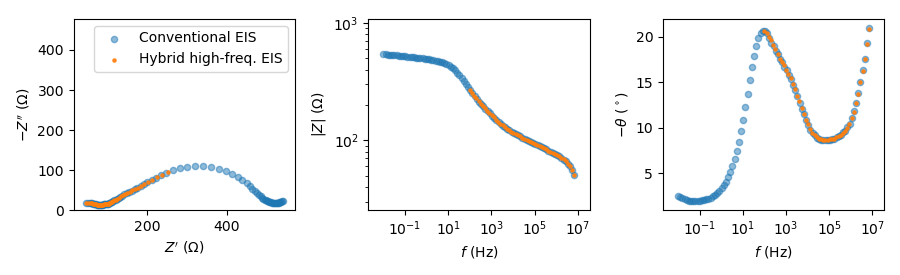

In [16]:
# Plot the conventional and high-frequency EIS data
axes = hplt.plot_eis(conv_ztup, label="Conventional EIS")
hplt.plot_eis(hztup, axes=axes, marker=".", alpha=0.9, label="Hybrid high-freq. EIS")

raw size: 59525
downsampled size: 490


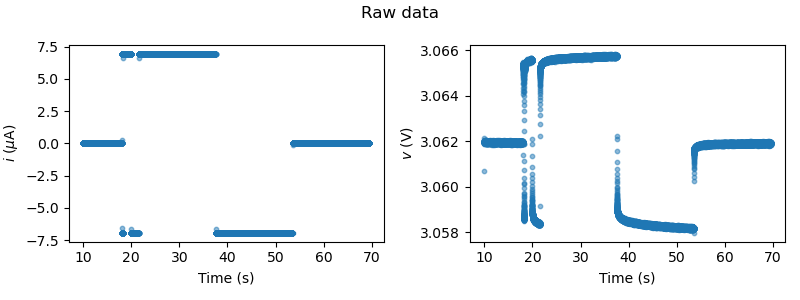

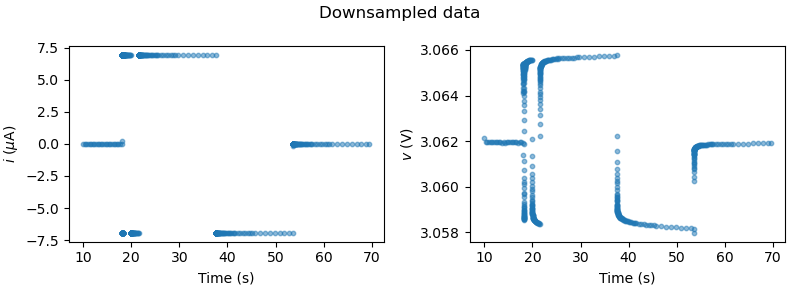

In [17]:
# We need to reduce the size of the time-domain data
# So we downsample it with an anti-aliasing filter

print(f"raw size: {len(hctup[0])}")
# Process the data
hctup_ds = process_tiv(*hctup)

# Plot the raw data
axes = hplt.plot_chrono(hctup)
fig = axes[0].get_figure()
fig.suptitle("Raw data")
fig.tight_layout()

# Plot the downsampled data
axes_ds = hplt.plot_chrono(hctup_ds)
fig_ds = axes_ds[0].get_figure()
fig_ds.suptitle("Downsampled data")
fig_ds.tight_layout()

## Hybrid data fit and validation

In [18]:
# Fit the hybrid data
# Required inputs: tuple of chrono data (t,i,v), tuple of freq-domain data (f, z)
# When fitting, we need to discard the 1st 1-2 time-domain samples after each current step (discard_first_n=1)
# This is due to erroneous Biologic behavior immediately after each current step

# We can use a flexible error structure by specifying chrono_error_structure=None, which usually yields best results
drt.fit_hybrid(*hctup_ds, *hztup, discard_first_n=1, 
               # Flexible error structure for chrono data: epsilon specifies inverse length scale for error magnitude
               chrono_error_structure=None, chrono_vmm_epsilon=4, 
               # Prior probability of outliers = 0.01: allows weight of anomalous points to be reduced
               outlier_p=0.01
    )

array([[<Axes: title={'center': 'DRT'}, xlabel='$\\tau$ (s)', ylabel='$\\gamma$ ($\\Omega$)'>,
        <Axes: title={'center': 'EIS Fit'}, xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>,
        <Axes: title={'center': 'Chrono Fit'}, xlabel='Time (s)', ylabel='$v$ (V)'>],
       [<Axes: title={'center': '$Z^\\prime$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$Z^\\prime$ ($\\Omega$)'>,
        <Axes: title={'center': '$Z^{\\prime\\prime}$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$-$$Z^{\\prime\\prime}$ ($\\Omega$)'>,
        <Axes: title={'center': 'Chrono Residuals'}, xlabel='Time (s)', ylabel='$v - \\hat{v}$ ($\\mu$V)'>]],
      dtype=object)

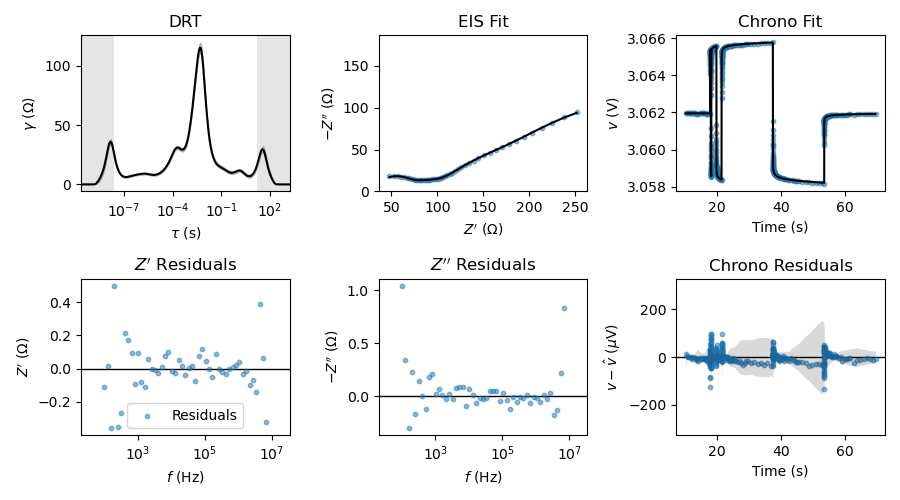

In [19]:
# Plot the fitting results
drt.plot_results()

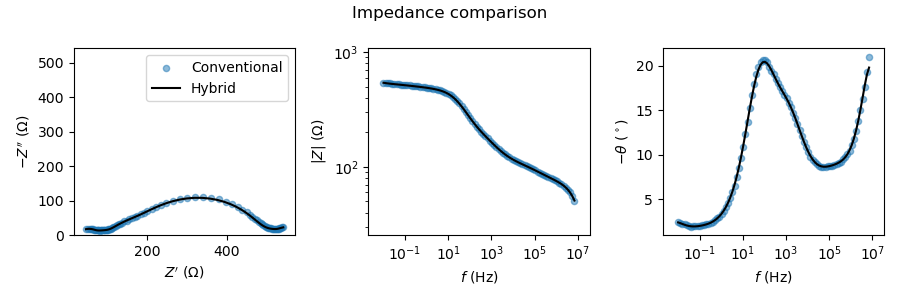

In [20]:
# Plot the impedance extracted from the hybrid measurement and compare it to the conventional impedance
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# Conventional data
hplt.plot_eis(conv_ztup, axes=axes, label="Conventional")

# Use the hybrid DRT to predict the impedance at the measured frequencies
f_meas = conv_ztup[0]
z_pred = drt.predict_z(f_meas)
# Plot the extracted hybrid impedance against conventional
hplt.plot_eis((f_meas, z_pred), axes=axes, plot_func="plot", label="Hybrid", c="k")

fig.suptitle("Impedance comparison")
fig.tight_layout()

The hybrid measurement reproduces the conventional result quite well. In general, results should look something like this. If hybrid results are substantially worse but the raw data looks good, there is likely an issue with the processing of the time-domain data (especially the first few samples after each step), which can be tricky to get right due to strange/variable behavior of measurement instruments or recording software.

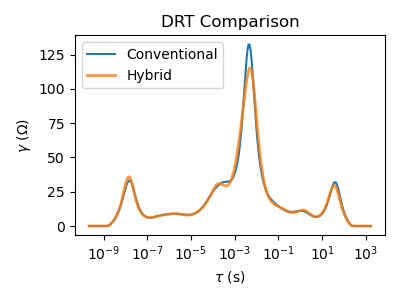

In [21]:
# Fit the DRT to the conventional dataset and compare to the hybrid DRT
drt_conv = drt.copy()
drt_conv.fit_eis(*conv_ztup)

ax = drt_conv.plot_distribution(label="Conventional")
drt.plot_distribution(label="Hybrid", ax=ax, alpha=0.8, lw=2, ls="-")

ax.legend()
ax.set_title("DRT Comparison")
ax.get_figure().tight_layout()

The DRTs from both measurements also align very well, indicating all of the same peak positions. The hybrid measurement suggests a slightly broader peak at $\tau \sim 10^{-2}$ s, which may be due to the slightly lower signal-to-noise ration inherent to time-domain data.
